# ML Immobilier - Californie


## Identify the problem and research a global vision

- **Objectif:** Predicting median home prices in California districts
- **Problem:** Supervised learning - Regression - Offline
- **Metrics:** RMSE

**Fondamental Analysis**

...

**Form analysis**
- *Identify the target:* median_house_value
- *Number of the rows and columns:* 20640, 10
- *Type of variables:* 1 categorical, 9 numerics
- *Identify missing values:* No missing values(NaN) except the variable total_bedrooms which contains 1% missing values

**Content analysis**
- *Visualize the target:* median_house_value is normalized (<=500000)
- *Understand the different variables:*
    - median_income is normalized [0. 5 - 15] with (1 = 10000$/year)
    - housing_median_age is normalized
    - The variables have very different scales
    - Many histograms are very skewed; they extend more to the right than to the left
- *Visualize features-target relationships:* The most promising variable for prediction median_house_value is median_income
- *Identify outliers:*


## Libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Get Data

In [44]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
            
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [45]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# I. Exploratory Data Analysis - EDA

**Objective:** Understand data in order to define a modeling startegy

**Form analysis**
 - *Identify the target:* median_house_value
 - *Number of the rows and columns:* 20640, 10
 - *Type of variables:* 1 categorical, 9 numerics
 - *Identify missing values:* No missing values(NaN) except the variable *total_bedrooms* which contains 1% missing values

**Content analysis**
 - *Visualize the target:* *median_house_value* is normalized (<=500000)
 - *Understand the different variables:*
     - *median_income* is normalized [0. 5 - 15] with (1 = 10000$/year)
     - *housing_median_age* is normalized
     - The variables have very different scales
     - Many histograms are very skewed; they extend more to the right than to the left
 - *Visualize features-target relationships:* The most promising variable for prediction *median_house_value* is *median_income*
 - *Identify outliers:*

## Form analysis

In [17]:
df = housing.copy()

In [18]:
df.shape

(20640, 10)

In [19]:
df.dtypes.value_counts()

float64    9
object     1
Name: count, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


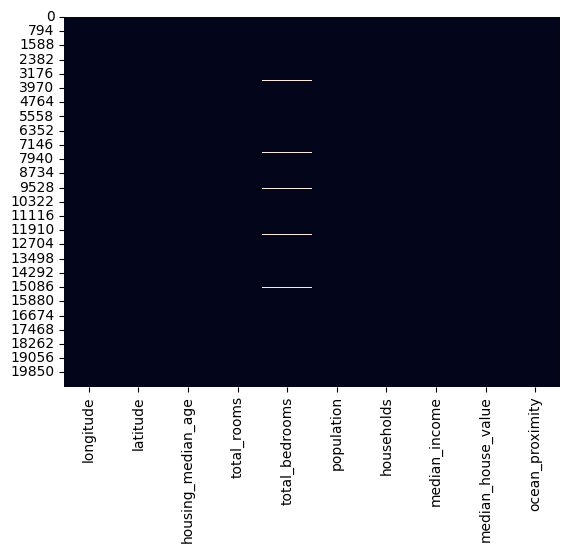

In [21]:
sns.heatmap(df.isna(), cbar=False);

## Content analysis
### Numeric variables

In [22]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


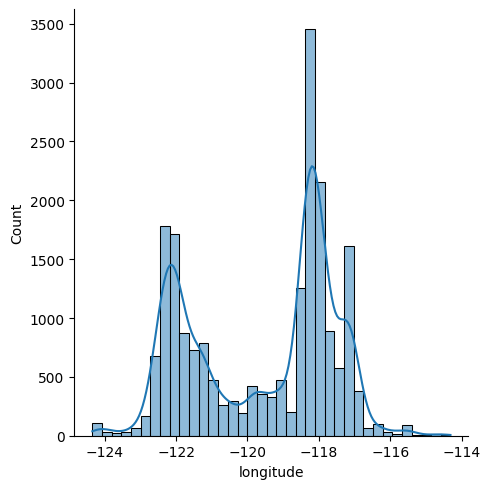

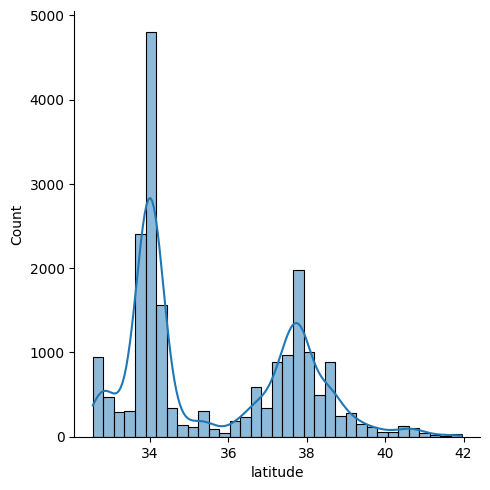

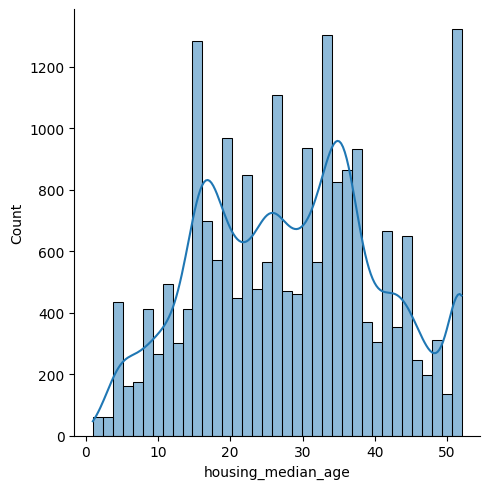

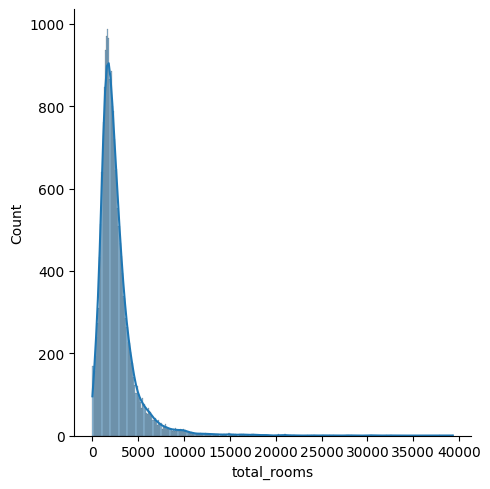

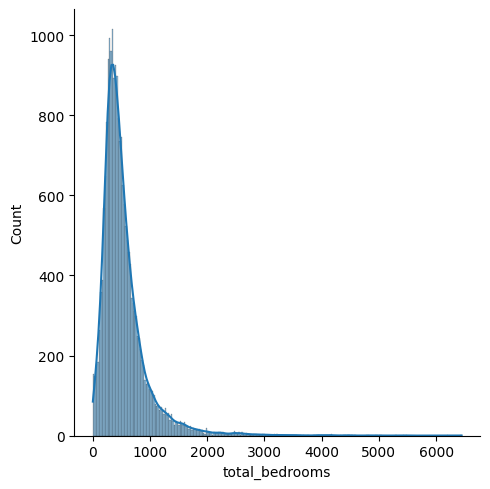

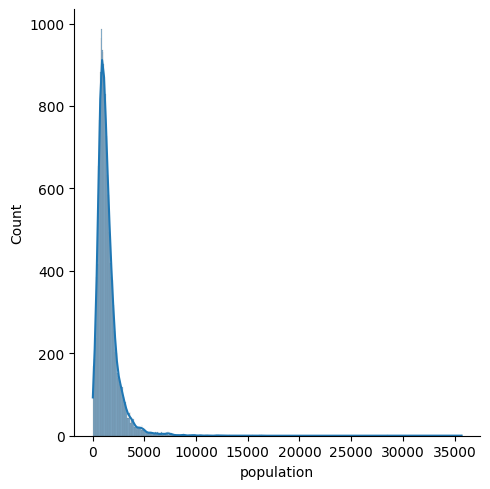

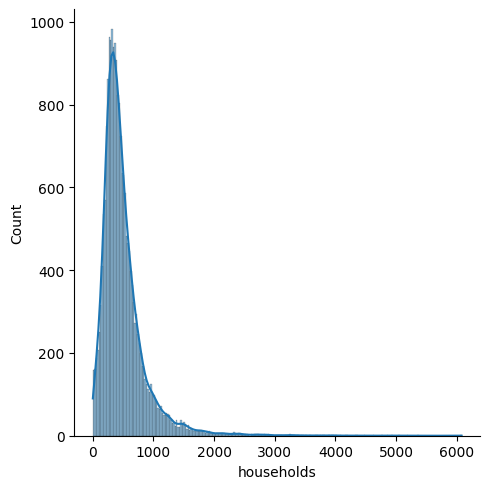

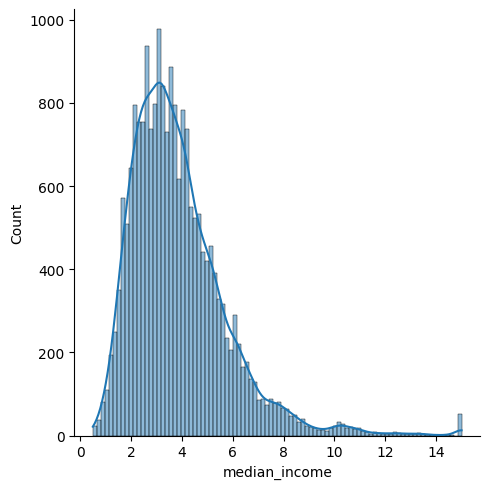

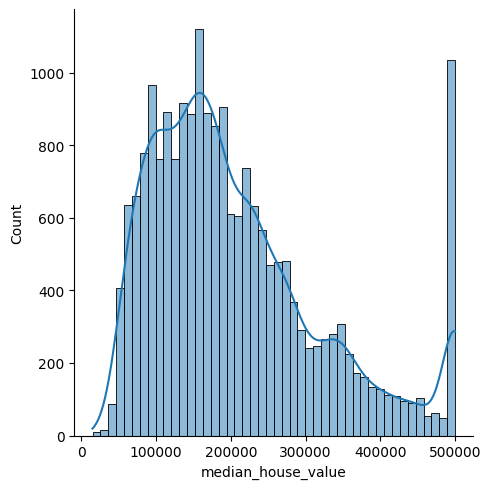

In [23]:
for col in df.select_dtypes('float'):
    sns.displot(df[col], kde=True)

### Categorical variables

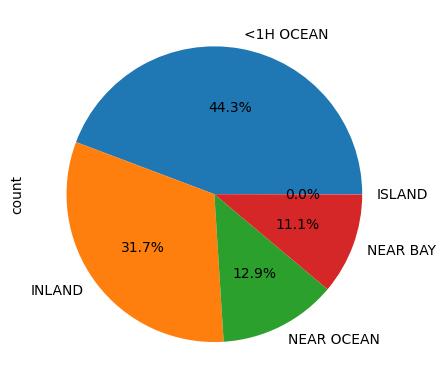

In [24]:
df['ocean_proximity'].value_counts().plot.pie(autopct='%1.1f%%');

## Create a Test and Train set

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Is the test_set representative of the different income brackets *median_income*?

In [27]:
df['income_cat'] = pd.cut(df['median_income'],
                          bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                         labels=[1, 2, 3, 4, 5])

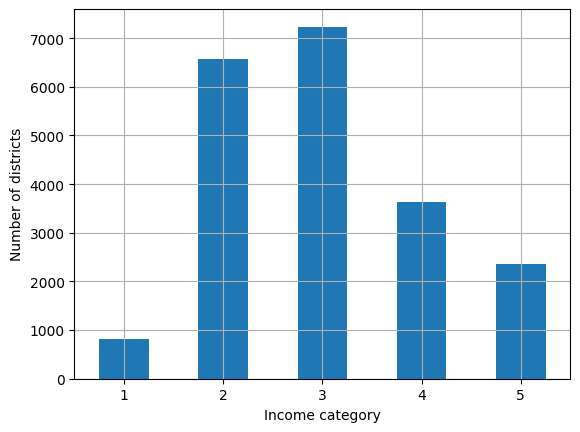

In [28]:
df['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts");

In [29]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df['income_cat'], random_state=42)

<Axes: xlabel='income_cat'>

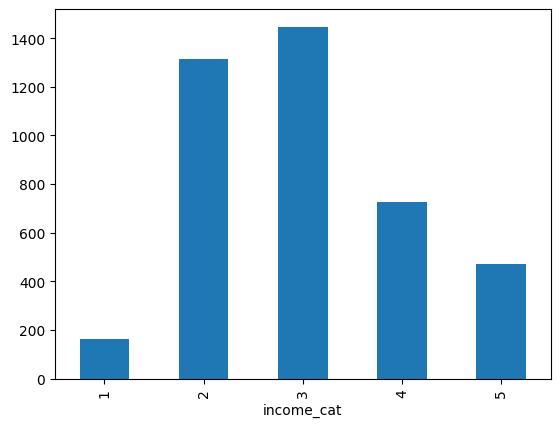

In [30]:
strat_test_set['income_cat'].value_counts().sort_index().plot.bar()

In [31]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [32]:
df_train = strat_train_set.copy()

### Visualizing Geographical Data

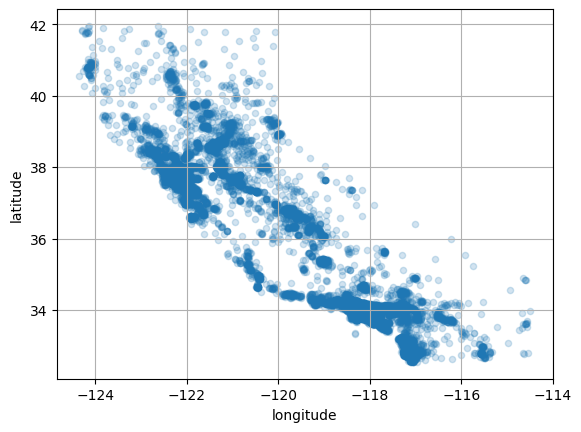

In [33]:
df_train.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2);

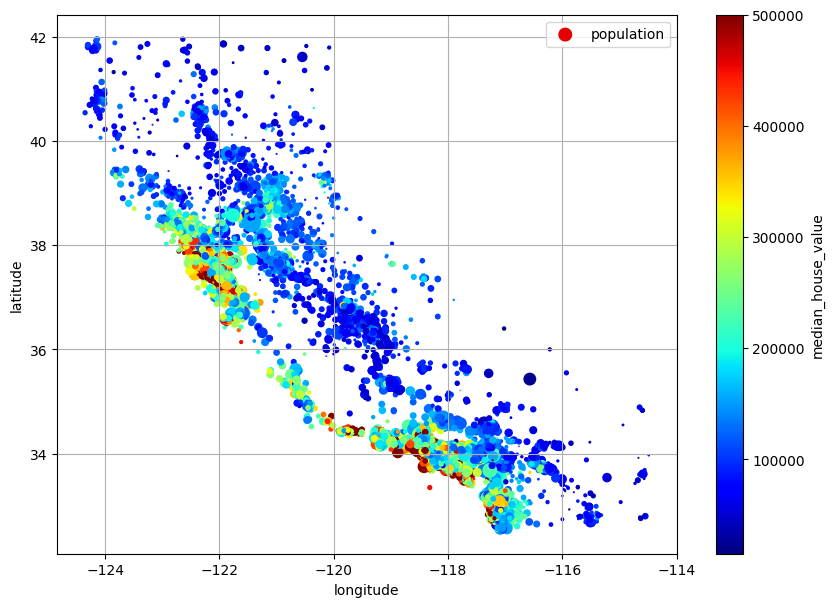

In [34]:
df_train.plot(kind='scatter', x='longitude', y='latitude', grid=True,
              s=df_train['population']/100, label='population',
              c='median_house_value', cmap='jet', colorbar=True,
              sharex=False, figsize=(10, 7));

### Looking for correlations

In [35]:
corr_matrix = df_train.corr(numeric_only=True)

In [36]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

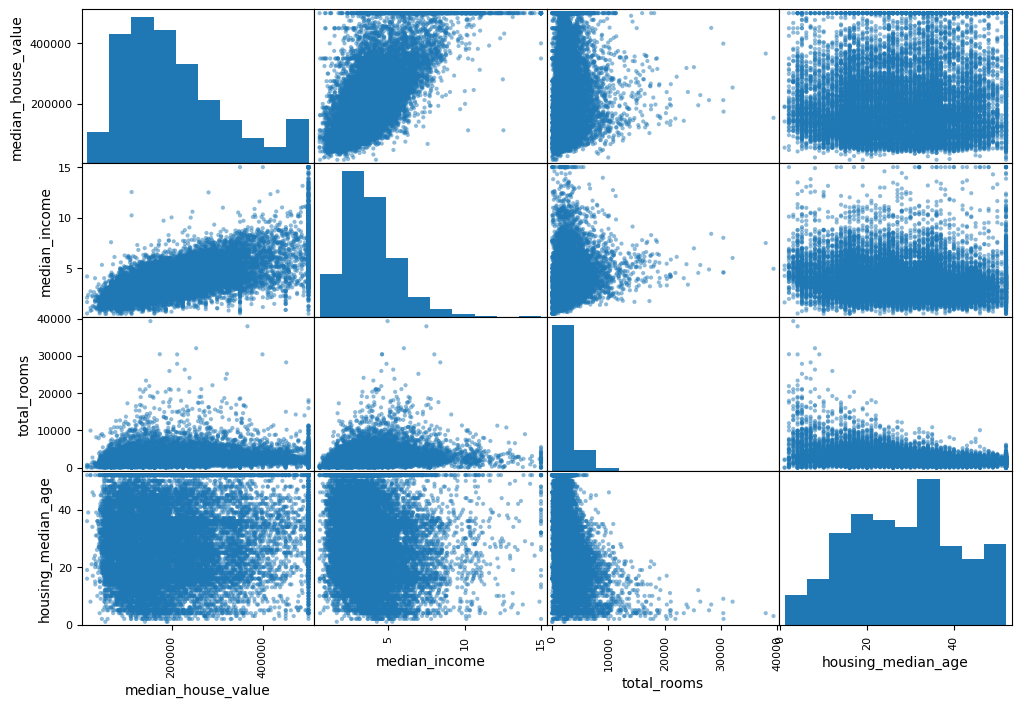

In [37]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(df_train[attributes], figsize=(12, 8));

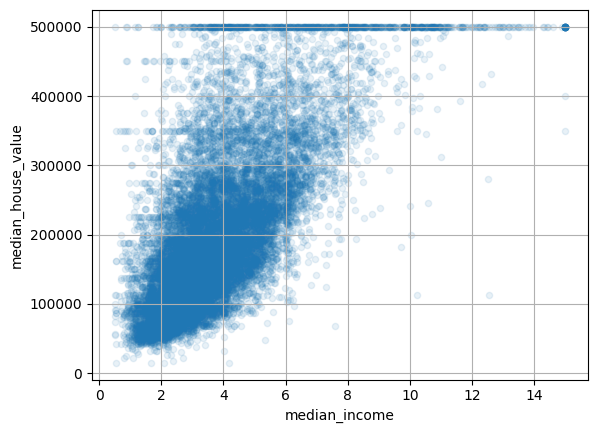

In [38]:
df_train.plot(kind='scatter', x='median_income', y='median_house_value', grid=True, alpha=0.1);

### Feature Engineering

In [39]:
df_train['rooms_per_house'] = df_train['total_rooms'] / df_train['households']
df_train['bedrooms_ratio'] = df_train['total_bedrooms'] / df_train['total_rooms']
df_train['people_per_house'] = df_train['population'] / df_train['households']

In [40]:
corr_matrix = df_train.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# II. Pre-Processing

In [329]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

## Data Cleaning

# III. Modeling

# IV. Evaluation

# V. Model Deployment, Monitoring, and Maintenance